# Windowing a Continuous-Frequency Sinusoids

In practice, we never work with infinite-duration sinusoids. When analyzing signals in the frequency domain, we must window them in time, which introduces spectral effects.

This notebook explores the effect of applying different window functions to a multicomponent sinusoidal signal in the time domain, and how these windows impact its representation in the frequency domain.


## Mathematical Background

Let $ x(t) = e^{j(2\pi f_0 t + \phi_0)} $ be a complex-valued sinusoid of frequency $ f_0 $ and phase $ \phi_0 $. In practice, we observe a finite segment of this signal by multiplying it with a time-limited window $ w(t) $:

$$
x_w(t) = x(t) \cdot w(t)
$$

According to the **convolution theorem**, the Fourier Transform of $ x_w(t) $ is:

$$
X_w(f) = X(f) * W(f)
$$

where $ W(f) $ is the Fourier Transform of the window. Hence, the ideal delta spectrum of $ x(t) $ becomes smeared by the spectral shape of the window.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.signal import get_window

from dsp.signals.fm import cfsig

sns.set_style("whitegrid")

## Rectangular Windowing

The most basic window is the rectangular window, which simply truncates the signal at the beginning and end of the observation interval.

This operation corresponds to a multiplication in time and therefore a convolution in the frequency domain. The result is the spectrum of the sinusoid smeared by the sinc-shaped spectrum of the rectangular window.


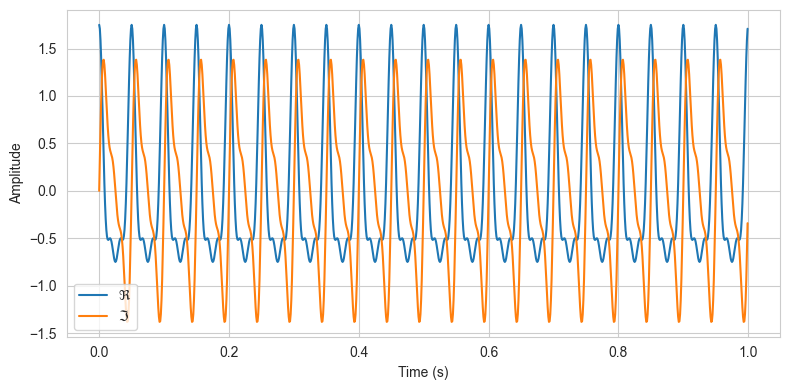

In [3]:
fs = 1000  # Sampling frequency [Hz]
dt = 1 / fs
dur = 1    # Duration of window in seconds
t = np.arange(0, dur, dt)

f0 = 20  # Frequency of the base sinusoid [Hz]
x = cfsig(t, f0) + 0.5 * cfsig(t, 2 * f0) + 0.25 * cfsig(t, 3 * f0) # Composite signal with multiple frequencies

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, np.real(x), label=r'$\Re$')
ax.plot(t, np.imag(x), label=r'$\Im$')
# ax.axis((0, dur/8, -1.5, 1.5))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.legend()
plt.tight_layout()
plt.show()


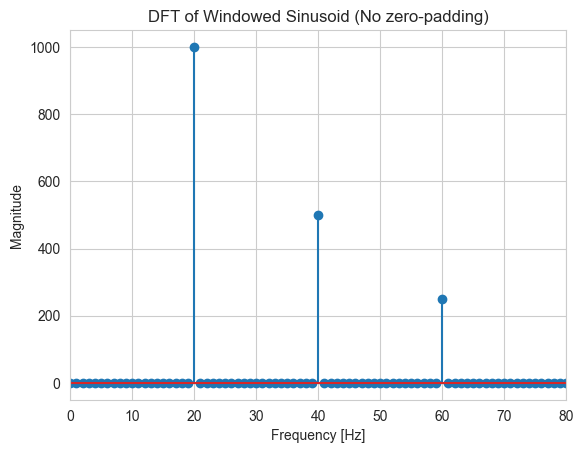

In [4]:
n = len(x)
nfft = n
df = fs / nfft
f = np.arange(-fs/2, fs/2, df) + (df if nfft % 2 else 0)

X = np.fft.fft(x, nfft)
X_shifted = np.fft.fftshift(np.abs(X))

plt.figure()
plt.stem(f, X_shifted)
plt.xlim(0, (3 * f0) + 20)
plt.title("DFT of Windowed Sinusoid (No zero-padding)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid(True)


## Zero-padding

Zero-padding the signal increases the frequency resolution of the DFT, allowing us to better approximate the continuous-time Fourier transform (CTFT).

It does **not** improve spectral content but makes peaks easier to identify.


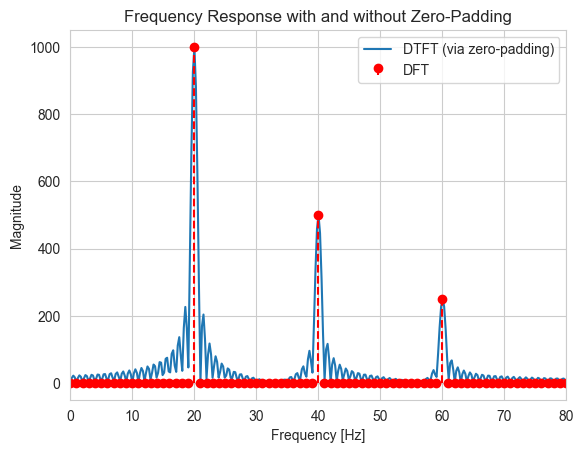

In [7]:
nfft_zp = 2 ** int(np.ceil(np.log2(4 * n)))  # 4x zero-padding
df_zp = fs / nfft_zp
f_zp = np.arange(-fs/2, fs/2, df_zp) + (df_zp if nfft_zp % 2 else 0)

X_zp = np.fft.fft(x, nfft_zp)
X_zp_shifted = np.fft.fftshift(np.abs(X_zp))

plt.figure()
plt.plot(f_zp, X_zp_shifted, label="DTFT (via zero-padding)")
plt.stem(f, X_shifted, linefmt='r--', markerfmt='ro', basefmt=' ', label="DFT")
plt.title("Frequency Response with and without Zero-Padding")
plt.xlim(0, (3 * f0) + 20)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True)


## Exploring Other Windows

We will now explore how applying other windows affects the spectrum:

- Hamming
- Hann
- Blackman
- Kaiser

Each of these windows reduces spectral leakage at the cost of increasing the main lobe width.


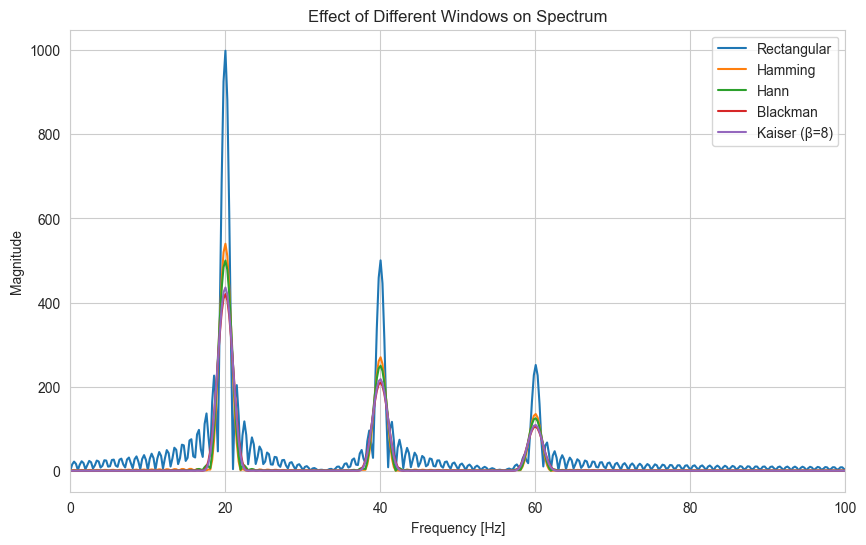

In [6]:
windows = {
    "Rectangular": np.ones_like(t),
    "Hamming": get_window("hamming", n),
    "Hann": get_window("hann", n),
    "Blackman": get_window("blackman", n),
    "Kaiser (β=8)": get_window(("kaiser", 8), n)
}

plt.figure(figsize=(10, 6))
for name, w in windows.items():
    x_win = x * w
    X_win = np.fft.fft(x_win, nfft_zp)
    X_win_shifted = np.fft.fftshift(np.abs(X_win))
    plt.plot(f_zp, X_win_shifted, label=name)

plt.xlim(0, 100)
plt.title("Effect of Different Windows on Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True)


## Conclusions

This notebook demonstrated how applying different window functions affects the spectral representation of a sinusoidal signal with a non-integer frequency.

### Key Takeaways:

- **Windowing is essential** when working with finite-length signals. The choice of window directly impacts the frequency resolution and spectral leakage in the resulting frequency analysis.
- The **rectangular window** provides the narrowest main lobe, but suffers from high sidelobe levels, leading to significant leakage.
- **Hann, Hamming, Blackman, and Kaiser** windows reduce leakage by attenuating the sidelobes at the expense of widening the main lobe.
- **Zero-padding** does not improve frequency resolution in a physical sense but offers a finer sampling of the DFT, providing a smoother and more interpretable frequency response.
- The **Kaiser window** offers flexibility by adjusting the β parameter, allowing for a trade-off between main lobe width and sidelobe attenuation.

In summary, windowing is not just a technicality—it's a crucial part of signal processing that must be tailored to the goals of the analysis. The optimal window depends on whether the priority is to resolve closely spaced frequencies (main lobe width) or to minimize leakage (sidelobe attenuation).
